This notebook is used to select random strava points within Austin region and characteristic data to those points for further analysis

In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry, ops

import warnings
warnings.filterwarnings("ignore")

In [28]:
strava=gpd.read_file('Final_data/strava_data')

#### Sampling points from strava (crowdsourced) 

In [29]:
#Selecting points from one point from each OSM segment
a=[]
border=[]
osm_ids=strava.osmId.unique()
for osm in osm_ids:
    osm_segment=strava[strava.osmId==osm]
    rows=len(osm_segment)
   
    #if even
    if (rows % 2) == 0:
        a=rows/2
        edge=osm_segment.iloc[[a]]
        d=pd.DataFrame(edge.boundary)
        d=d.iloc[0,0][1]
        border.append(d)
    else:
        a=int(rows/2)
        edge=osm_segment.iloc[[a]]
        d=pd.DataFrame(edge.boundary)
        d=d.iloc[0,0][1]
        border.append(d)
#Converting the selected points into geodata
d=pd.DataFrame(border)
C=gpd.GeoDataFrame(d, geometry=d[0],crs='EPSG:4326')
C=C.to_crs('EPSG:6588')

# Extracting data for just Austin region
austin_regions=gpd.read_file('austin_regions/Export_regions')
austin_regions=austin_regions.to_crs('EPSG:6588')
austin=austin_regions.dissolve()
WithinT=None
C['withinT']=''
withinTlist = []
for i in C.geometry:
    withinT = i.within(austin.geometry.values[0])
    withinTlist.append(withinT)
C['withinT'] = withinTlist
D=C.loc[C.withinT]

#### Adding demographic data

In [36]:
#Buffer
D.reset_index(drop=True, inplace=True)
D['index']=D.index
C_buffer=D.copy(deep=True)

#setting a 24ft buffer to join the type of bicycle facility
C_buffer.geometry=D.geometry.buffer(5280) #5280ft ~ 1mile

In [37]:

#Texas census block
shp_tx=gpd.read_file('tl_2020_48_bg')
shp_tx.to_crs(epsg=6588, inplace=True)
shp_tx.set_index(shp_tx.GEOID.astype(float),drop=True,inplace=True)
shp_tx=shp_tx.loc[:,["geometry"]]

#demographic file
dem20=pd.read_csv('demographic data/ACS 2020 (5-year estimate).csv')
dem20=dem20.drop([0])
#getting rid of empty columns
empty_cols = [col for col in dem20.columns if dem20[col].isnull().all()]
dem20.drop(empty_cols,axis=1,inplace=True)
#Treating Nan in per capita income'. We fill na with zero as the population in also zero in this case
dem20.loc[(dem20['Per Capita Income (In 2020 Inflation Adjusted Dollars)'].isna()),('Per Capita Income (In 2020 Inflation Adjusted Dollars)')]='0'


#setting FIPS as index
dem20.set_index(dem20.FIPS,drop=True,inplace=True)
dem20.index=dem20.index.astype(float)

#Joining socio-demographic data to census block group
shp_dem20=pd.concat([dem20,shp_tx],axis=1, join="inner") 
gdf_dem20=gpd.GeoDataFrame(shp_dem20, geometry=shp_dem20.geometry, crs="EPSG:6588")

In [38]:
C_buffer['index']=C_buffer.index
#to get the sum
gdf_dem20["area_bg"]=gdf_dem20.geometry.area
inter20 = gpd.overlay(gdf_dem20,C_buffer, how='intersections')
inter20["area"] = inter20['geometry'].area

In [39]:
def get_buffer_demographic(inter):
    # def ws(x):
    # print(x)
    # factor=(inter.loc[x.index, "area"])/(inter.loc[x.index, "area_bg"])
    # print("fact",factor)
    # return np.sum(x*factor)

    ws= lambda x: round(np.sum(x*(inter.loc[x.index, "area"])/(inter.loc[x.index, "area_bg"])),0)

    dict_columns_type = {'Total Population:': int,
                        'Total Population: Male': int,
                         'Total Population: Female': int,
                         'Total Population: 18 to 24 Years': int,
                         'Total Population: 25 to 34 Years': int,
                         'Total Population: 35 to 44 Years': int,
                         'Total Population: 45 to 54 Years': int,
                         'Total Population: 55 to 64 Years': int,
                         'Total Population: 65 to 74 Years': int,
                         'Total Population: 75 to 84 Years': int,
                         'Total Population: 85 Years and Over': int,
                         'Total Population: White Alone': int,
                         'Total Population: Black or African American Alone':int,
                         'Total Population: American Indian and Alaska Native Alone':int,
                         'Total Population: Asian Alone': int,
                         'Total Population: Two or More Races':int,
                         'Households:':int,
                         'Households: Family Households':int,
                         'Households: Nonfamily Households':int,
                         'Population 25 Years and Over: Some College':int,
                          "Population 25 Years and Over: Bachelor's Degree":int,
                          "Population 25 Years and Over: Master's Degree":int,
                          'Population 25 Years and Over: Professional School Degree':int,
                          'Population 25 Years and Over: Doctorate Degree':int,
                          'In Labor Force 16 Years and Over:':int,
                          'Per Capita Income (In 2020 Inflation Adjusted Dollars)':int,
                          'Owner Occupied Housing Units':int

      }

    inter = inter.astype(dict_columns_type)
    f={'Total Population: Male': ws,'Total Population:':ws,'Total Population: Female':ws,
       'Total Population: 18 to 24 Years': ws,
     'Total Population: 25 to 34 Years': ws,
     'Total Population: 35 to 44 Years': ws,
     'Total Population: 45 to 54 Years': ws,
     'Total Population: 55 to 64 Years': ws,
     'Total Population: 65 to 74 Years': ws,
     'Total Population: 75 to 84 Years': ws,
     'Total Population: 85 Years and Over': ws,
     'Total Population: White Alone': ws,
     'Total Population: Black or African American Alone':ws,
     'Total Population: American Indian and Alaska Native Alone':ws,
     'Total Population: Asian Alone': ws,
     'Total Population: Two or More Races':ws,
     'Households:':ws,
     'Households: Family Households':ws,
     'Households: Nonfamily Households':ws,

     'Population 25 Years and Over: Some College':ws,
     "Population 25 Years and Over: Bachelor's Degree":ws,
     "Population 25 Years and Over: Master's Degree":ws,
     'Population 25 Years and Over: Professional School Degree':ws,
     'Population 25 Years and Over: Doctorate Degree':ws,
     'In Labor Force 16 Years and Over:':ws,
     'Per Capita Income (In 2020 Inflation Adjusted Dollars)':ws,
     'Owner Occupied Housing Units':ws

      }
    newdf=inter.groupby("index").agg(f)
    return newdf

In [40]:
newdf=get_buffer_demographic(inter20)
C_=pd.concat([newdf,C_buffer],axis=1)
C=gpd.GeoDataFrame(C_, geometry=C_[0])
C=C.to_crs("EPSG:6588")

<AxesSubplot:>

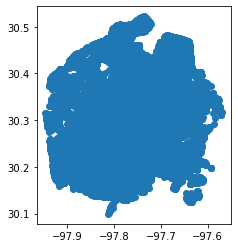

In [60]:
C.plot()

#### More Built Environment

In [13]:
#Buffer for land use
def LetsBuffer(C,sizeft):
    C.reset_index(drop=True, inplace=True)
    C.geometry=C.geometry.buffer(sizeft) 
    return(C)

##### Land use

In [14]:
#Making a 0.5 mile buffer
C_buffer=LetsBuffer(C,sizeft=2640) #0.5Miles

In [ ]:
#Inporting landuse data extracted from city's website
land=gpd.read_file("built environment data/Land Use Inventory Detailed")
land=land.to_crs('EPSG:6588')
land=land.loc[:,['land_use','geometry']]

In [17]:
#Calculating Land Use ENtropy
land['area_lu']=land.geometry.area
C_buffer['area_buffer']=C_buffer.geometry.area
#Calculating areas
C_buffer['area_buffer']=C_buffer.geometry.area
#Making a seperate columns named indexx to identify the rows of each buffer points (since overlay function doesot indicate it)
C_buffer_1=C_buffer.reset_index().rename(columns={'level_0':'indexx'})
'''#E-scooter'''
a=gpd.overlay(C_buffer_1,land, how='intersection', keep_geom_type=True)
#a=C_s_buffer.sjoin(land, how='left', predicate='intersects')
a=a[a.land_use.notna()]

In [19]:
#Calculating land use mix
a_index=a.indexx.unique()
entropy_df=[]
i=0
for indx in a_index:
    df=a[a.indexx==indx]
    df['area_lu']=df.geometry.area
    df['area_lu_prop']=df.area_lu/df.area_buffer
    b=df.groupby(df.land_use)['area_lu_prop'].sum()
    lu=b[b==b.max()].index[0]
    entropy=-1*sum(b*np.log(b))/np.log(len(b))
    dic={'indx':indx,
        'lu':lu,
        'lu_entropy':entropy}
    entropy_df.append(dic)
output_entropy=pd.DataFrame(entropy_df)
output_entropy.set_index('indx', inplace=True)

#Add to escooter dataframe C_s
#C_s.reset_index(drop=True, inplace=True)
C=pd.concat([output_entropy,C],axis=1)

In [24]:
def clean_lu(C):
    C['land_use']=''   
    C.loc[(C.lu==100),'land_use']='single_fam'
    C.loc[(C.lu>=101) & (C.lu<=240),'land_use']='aprt/condo'
    C.loc[(C.lu>=300) & (C.lu<=400),'land_use']='commercial'
    C.loc[(C.lu>=500) & (C.lu<=599),'land_use']='warehouse'
    C.loc[(C.lu>=600) & (C.lu<=699),'land_use']='gov-edu'
    C.loc[(C.lu>=700) & (C.lu<=799),'land_use']='park'
    C.loc[(C.lu>=800) & (C.lu<=899),'land_use']='transport'
    C.loc[(C.lu>=900) & (C.lu<=999),'land_use']='undev'
    return(C)
C=clean_lu(C)

Land Use Mix indicates the level of diversity of land use types within an area.<br>
Two indices can be calculated by Land Use Analyzer, the Entropy Index and the Herfindahl-Hirschman Index (HHI). The Entropy Index is an adaptation of Shanon’s Entropy: <br>
Entropy= - (Sum(Pi* ln(Pi))/ln(k))
where Pj, is the percentage of each land use type j in the area and k is the total number of land use types. The percentage Pj is calculated in terms of area.

In [ ]:
# #manualy cleaning
# """
# Landuse numbers:
# 1. 100 = single home
# 2. 200 = (113 - 240) mobile homes, apartments, condo, duplexes, etc
# 3. 300 = (300-400), commercial, mixed use, office
# 4. 500 = manufecturing, warehose, mining, etc
# 5. 600 = Gov services, educational, meeting assembly, museusm, library, club
# 6. 700 = park, open area, common area
# 7. 800 = railway, transportation facilities
# 8. 900 = undeveloped
# """


# d=b.astype(str)
# d[d=='[]']='900.0'
# #d[d=='[220. 300.]']='300'
# #d[d=='[220. 300.]']='300'
# #d[d=='[220. 300.]']='300'
# d[d=='[220. 300.]']='300'

# d[d=='[150. 220.]']='200'
# d[d=='[750. 910.]']='900'

# d[d=='[100. 300.]']='300'
# d[d=='[100. 400.]']='300'
# d[d=='[100. 910.]']='100'

# d[d=='[510. 910.]']='500'
# d[d=='[400. 750.]']='300'
# d[d=='[300. 750.]']='300'

# d[d=='[300. 520.]']='300'
# d[d=='[300. 400.]']='300'
# d[d=='[300. 900.]']='300'
# d[d=='[900. 910.]']='900'

# d[d=='[560. 640. 710.]']='500'
# d[d=='[100. 300. 400.]']='300'
# d[d=='[100. 160. 750.]']='200'
# d[d=='[400. 740. 900.]']='300'
# #d[d=='[100. 300. 400.]']='300'
# #d[d=='[100. 300. 400.]']='300'
# #d[d=='[100. 300. 400.]']='300'
# #d[d=='[100. 300. 400.]']='300'


# d[d=='[300. 910.]']='300'
# d[d=='[100. 160.]']='200'
# d[d=='[100. 113.]']='200'
# d[d=='[630. 740.]']='600'
# d[d=='[560. 870.]']='500'
# d[d=='[300. 510.]']='300'
# d[d=='[100. 520.]']='100'
# d[d=='[220. 900.]']='200'
# d[d=='[510. 520.]']='500'
# d[d=='[570. 900.]']='500'
# d[d=='[710. 900.]']='300'
# d[d=='[100. 210.]']='500'
# d[d=='[750. 940.]']='900'
# d[d=='[160. 910.]']='900'
# d[d=='[100. 220.]']='200'
# d[d=='[100. 710.]']='100'
# d[d=='[560. 740.]']='500'
# d[d=='[520. 900.]']='900'
# d[d== '[150. 520.]']='500'
# #d[d=='[520. 900.]']='900'
# #d[d=='[100. 300. 400.]']='300'
# #d[d=='[520. 900.]']='900'
# #d[d=='[100. 300. 400.]']='300'
# #d[d=='[520. 900.]']='900'
# #d[d=='[100. 300. 400.]']='300'

# #Since its too many now the first item on a given element will be chosen 
# d_list=[]
# for i in d:
#     j=i[0:5]
#     if j[0:1] == '[':
#         k=j[1:4]
#         d_list.append(k)
#     else:
#         d_list.append(j[0:3])
# d_list


# d_list=pd.DataFrame(d_list).astype(float)


In [ ]:
# C['land_use_num']=d_list
# C['land_use']=''

In [ ]:
#Information for manualy cleaning
"""
Landuse numbers:
1. 100 = single home
2. 200 = (113 - 240) mobile homes, apartments, condo, duplexes, etc
3. 300 = (300-400), commercial, mixed use, office
4. 500 = manufecturing, warehose, mining, etc
5. 600 = Gov services, educational, meeting assembly, museusm, library, club
6. 700 = park, open area, common area
7. 800 = railway, transportation facilities
8. 900 = undeveloped
"""

'\nLanduse numbers:\n1. 100 = single home\n2. 200 = (113 - 240) mobile homes, apartments, condo, duplexes, etc\n3. 300 = (300-400), commercial, mixed use, office\n4. 500 = manufecturing, warehose, mining, etc\n5. 600 = Gov services, educational, meeting assembly, museusm, library, club\n6. 700 = park, open area, common area\n7. 800 = railway, transportation facilities\n8. 900 = undeveloped\n'

In [31]:
C=C[C.lu.notna()]
C=C[C.lu_entropy!=np.inf]
C=C[C['Total Population:'].notna()]

##### Trail

In [73]:
C_buffer=gpd.GeoDataFrame(C, geometry=gpd.points_from_xy(C.lon, C.lat),crs='EPSG:4326')
C_buffer=C_buffer.to_crs('EPSG:6588')
#Buffer
C_buffer.geometry=C_buffer.geometry.buffer(50) #50ft 
#Importing trail data
trail = gpd.read_file('built environment data/TRANSPORTATION_urban_trails_network', crs='EPSG:6588')
trail=trail.to_crs('EPSG:6588')

In [75]:
#Joining
a1=C_buffer.sjoin(trail, how='left', predicate='intersects')
C['trail']='no_trail'
C.loc[(a1[a1.build_stat.notna()].index.unique()),'trail']='trail'

##### bike facilities

In [99]:
#Buffer
C.reset_index(drop=True, inplace=True)
C_buffer=gpd.GeoDataFrame(C, geometry=gpd.points_from_xy(C.lon, C.lat),crs='EPSG:4326')
C_buffer=C_buffer.to_crs('EPSG:6588')

#setting a 24ft buffer to join the type of bicycle facility
C_buffer.geometry=C_buffer.geometry.buffer(12) 

In [100]:
bike_type=gpd.read_file("built environment data/TRANSPORTATION_bicycle_facilities")
bike_type=bike_type.to_crs('EPSG:6588')
#joining
a=C_buffer.sjoin(bike_type, how='left', predicate='intersects')
#Grouping
b=a.groupby(a.index)['bicycle_fa'].agg(pd.Series.mode) #Simply aggregation and maximum frequency is used because all index groups was checked and all same indexes had same bicycle_fa.
#Adding to C
d=b.astype(str)
d[d=='[]']=''
C['bike_fac12']=d

In [ ]:

#categorizing bike facilities into three types
"""
'Trail lane' : Trail lanes
'bike lane' : Normal one line seperated bike lanes. 
'Buffer' : two marked line with some distance within them.
'protected' : lane seperated with some form of protective structure.  
"""

"\n'Trail lane' : Trail lanes\n'bike lane' : Normal one line seperated bike lanes. \n'Buffer' : two marked line with some distance within them.\n'protected' : lane seperated with some form of protective structure.  \n"

In [119]:
#Re-naming
#Trail
C.loc[(C.bike_fac12=='Trail - Paved'),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Bridge' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=='Trail - Unpaved'),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shoulder' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=='Bridge'),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Trail - Paved' 'Wide Curb Lane']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Bike Lane - Climbing' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Bridge' 'Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Bridge' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
#C.loc[(C.bike_fac12=="['Bike Lane - Climbing' 'Trail - Paved']"),('bike_fac12')]='Trail Lane'

C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Trail - Paved' 'Trail - Unpaved']"),('bike_fac12')]='Trail Lane'

#Bike Lane
C.loc[(C.bike_fac12=='Bike Lane'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Wide Curb Lane'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Bike Lane - Climbing'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Shared Lane'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Bike Lane - wParking'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bridge' 'Shared Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Shoulder'),('bike_fac12')]='Bike Lane'

C.loc[(C.bike_fac12=="['Shared Lane' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Shoulder' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'

C.loc[(C.bike_fac12=="['Bike Lane' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Shared Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - wParking']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=='Sharrows'),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Neighborhood Bikeway']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Climbing']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Sharrows' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Bike Lane' 'Shoulder']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'

C.loc[(C.bike_fac12=="['Bike Lane' 'Shared Lane' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane - wParking' 'Shared Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane - Climbing' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Shared Lane' 'Sharrows']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Neighborhood Bikeway' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane - Climbing' 'Sharrows']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12=="['Bike Lane' 'Sharrows' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Shared Lane' 'Shoulder']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Bike Lane' 'Sharrows']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Bike Lane' 'Bike Lane - Climbing' 'Neighborhood Bikeway']"),('bike_fac12')]='Bike Lane'
C.loc[(C.bike_fac12== "['Neighborhood Bikeway' 'Shared Lane']"),('bike_fac12')]='Bike Lane'
# C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
# C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
# C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
# C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'
# C.loc[(C.bike_fac12== "['Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Bike Lane'

#Buffer
C.loc[(C.bike_fac12=='Bike Lane - Buffered'),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Wide Curb Lane']"),('bike_fac12')]='Buffer'

C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Buffered']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Buffered' 'Sharrows' 'Wide Curb Lane']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Buffered' 'Shared Lane']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Bike Lane - Climbing']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Neighborhood Bikeway' 'Sharrows' 'Wide Curb Lane']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Neighborhood Bikeway']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Bike Lane - wParking']"),('bike_fac12')]='Buffer'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Shared Lane']"),('bike_fac12')]='Buffer'
#protected
C.loc[(C.bike_fac12=='Bike Lane - Protected Two-Way'),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=='Bike Lane - Protected One-Way'),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected Two-Way' 'Trail - Unpaved']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=='Neighborhood Bikeway'),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected One-Way' 'Trail - Unpaved']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Protected One-Way']"),('bike_fac12')]='Protected'

C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Bike Lane - Protected One-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12== "['Bike Lane - Protected One-Way' 'Shared Lane']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected One-Way' 'Bike Lane - Protected Two-Way'\n 'Wide Curb Lane']"),('bike_fac12')]='Protected'

C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Protected One-Way' 'Wide Curb Lane']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Climbing' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected Two-Way' 'Shared Lane']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected Two-Way' 'Trail - Paved']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected Two-Way' 'Wide Curb Lane']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected Two-Way' 'Bike Lane - wParking' 'Wide Curb Lane']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Buffered' 'Bike Lane - Protected One-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Buffered' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected One-Way' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected One-Way' 'Trail - Paved']"),('bike_fac12')]='Protected'
C.loc[(C.bike_fac12=="['Bike Lane - Protected One-Way' 'Bike Lane - wParking']"),('bike_fac12')]='Protected'
#C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'
#C.loc[(C.bike_fac12=="['Bike Lane' 'Bike Lane - Protected Two-Way']"),('bike_fac12')]='Protected'

#None
C.loc[(C.bike_fac12==''),('bike_fac12')]='No bike lane'


In [120]:
C.bike_fac12.unique()

array(['No bike lane', 'Bike Lane', 'Buffer', 'Trail Lane', 'Protected'],
      dtype=object)

In [121]:
C.to_csv("backup/C_random_points_demographic_lu_bikefac.csv", index=False)

#### Smart Location

In [122]:
smrt = gpd.read_file('SmartLocationDatabase/SmartLocationDatabase.gdb', crs='EPSG:4326')
smrt=smrt.loc[:,["GEOID10",'GEOID20','Ac_Unpr','D3A','D3AMM','D3APO','D3B','NatWalkInd','D4A','D4C','D4D', "geometry"]]
smrt.set_index(smrt.GEOID20.astype(float), drop=True, inplace=True)
smrt.to_crs('EPSG:6588',inplace=True)

Rows woth values -99999 are deleted.
 A value of “-99999” was assigned to SLD transit-based variables (D4 and D5b, D5d) that exceeded distance
thresholds or did not have GTFS data coverage. Shoreline or CBGs in water bodies with no land area, no
population and no jobs were also assigned a value of “-99999”. 

In [123]:
smrt.drop(smrt[smrt.D4A<0].index, inplace=True)
smrt.drop(smrt[smrt.D4C<0].index, inplace=True)
smrt.drop(smrt[smrt.D4D<0].index, inplace=True)

In [124]:
#Buffer
C_buffer=gpd.GeoDataFrame(C, geometry=gpd.points_from_xy(C.lon, C.lat),crs='EPSG:4326')
C_buffer=C_buffer.to_crs('EPSG:6588')

#setting a 24ft buffer to join the type of bicycle facility
C_buffer.geometry=C_buffer.geometry.buffer(5280) #1mile
C_buffer=C_buffer.reset_index().rename(columns={"index":"SL"})

In [127]:
inter=C_buffer.overlay(smrt, how='intersection')
inter["smrt_area"] = inter['geometry'].area
#inter['SL']=inter.index
inter.reset_index(inplace=True, drop=True)

In [128]:
def get_buffer_built(inter):
   

    wm = lambda x: np.average(x, weights=inter.loc[x.index, "smrt_area"]) 

    f={'Ac_Unpr': wm,
       'D3A':wm,
       'D3AMM':wm,
       'D3APO': wm,
       'D3B': wm,
       'NatWalkInd':wm,
       'D4A':wm,
       'D4C':wm,
       'D4D':wm,
      }
    newdf=inter.groupby('SL').agg(f)
    return newdf

In [129]:
ddd=get_buffer_built(inter)
C=pd.concat([C,ddd],axis=1)

In [130]:
C.to_csv("backup/C_random_points_demographic_lu_bikefac_smart.csv", index=False)

### Strava

In [133]:
strava=gpd.read_file('Final_data/strava_data')
strava_g=gpd.GeoDataFrame(strava, geometry=strava.geometry)

In [137]:
C1=gpd.GeoDataFrame(C, geometry=gpd.points_from_xy(C.lon, C.lat),crs='EPSG:4326')

(30.2105, 30.2125)

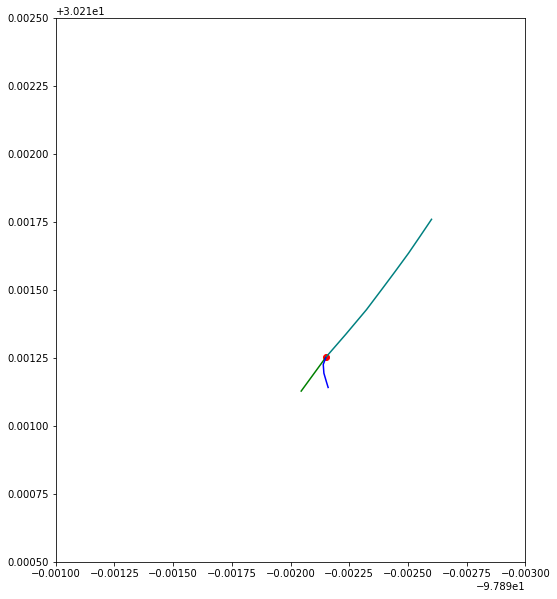

In [138]:

C1.lat=C1.lat.astype(str)
C1.lon=C1.lon.astype(str)
#PLOT
fig, ax=plt.subplots(1, figsize=(10,10))
strava_g[strava_g.edgeUID==321595572].plot(ax=ax, color='green')
strava_g[strava_g.edgeUID==321595571].plot(ax=ax, color='blue')
strava_g[strava_g.edgeUID==321595574].plot(ax=ax, color='teal')
C1[(C1.lat=='30.2112533')].plot(ax=ax, color='red')
ax.set_xlim(-97.891,-97.893)
ax.set_ylim(30.2105,30.2125)

In [140]:
a2=C1.sjoin(strava_g, how='left', predicate='intersects')
b2=a2.groupby(['lon','lat']).agg(max)

In [150]:
b2

,,lu,lu_entropy,Total Population: Male,Total Population:,Total Population: Female,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,...,str_bik_18,str_bik_19,str_bik_20,str_bik_21,str_bik_22,str_ped_18,str_ped_19,str_ped_20,str_ped_21,str_ped_22
lon,lat,,,,,,,,,,,,,,,,,,,,,
-97.5687002,30.317866,900.0,0.533644,141.0,270.0,129.0,13.0,49.0,28.0,34.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5706886,30.3112064,910.0,0.711558,141.0,271.0,130.0,13.0,50.0,28.0,34.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5712448,30.3110584,910.0,0.699182,141.0,272.0,131.0,13.0,50.0,28.0,34.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5740211,30.327225,900.0,0.636184,141.0,280.0,139.0,15.0,51.0,27.0,35.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5742356,30.3287214,900.0,0.547198,158.0,314.0,156.0,19.0,56.0,34.0,39.0,56.0,...,15.755572,17.071189,22.351705,19.732677,16.527223,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-97.9433023,30.2877568,910.0,0.363207,275.0,582.0,307.0,31.0,50.0,69.0,139.0,83.0,...,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN
-97.9433672,30.2905147,910.0,0.248841,280.0,592.0,311.0,27.0,50.0,72.0,145.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.94357,30.292504,910.0,0.243130,286.0,601.0,315.0,26.0,50.0,74.0,148.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
d=pd.DataFrame(b2.index.tolist())
b2['lon']=d[0]
b2['lat']=d[1]

In [152]:
b2

,,lu,lu_entropy,Total Population: Male,Total Population:,Total Population: Female,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,...,str_bik_20,str_bik_21,str_bik_22,str_ped_18,str_ped_19,str_ped_20,str_ped_21,str_ped_22,lon,lat
lon,lat,,,,,,,,,,,,,,,,,,,,,
-97.5687002,30.317866,900.0,0.533644,141.0,270.0,129.0,13.0,49.0,28.0,34.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5706886,30.3112064,910.0,0.711558,141.0,271.0,130.0,13.0,50.0,28.0,34.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5712448,30.3110584,910.0,0.699182,141.0,272.0,131.0,13.0,50.0,28.0,34.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5740211,30.327225,900.0,0.636184,141.0,280.0,139.0,15.0,51.0,27.0,35.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.5742356,30.3287214,900.0,0.547198,158.0,314.0,156.0,19.0,56.0,34.0,39.0,56.0,...,22.351705,19.732677,16.527223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-97.9433023,30.2877568,910.0,0.363207,275.0,582.0,307.0,31.0,50.0,69.0,139.0,83.0,...,NaN,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.9433672,30.2905147,910.0,0.248841,280.0,592.0,311.0,27.0,50.0,72.0,145.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-97.94357,30.292504,910.0,0.243130,286.0,601.0,315.0,26.0,50.0,74.0,148.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
b2.to_csv("Final_data/FullRandomData.csv", index=False)

In [154]:
fullrandomdata=pd.read_csv("Final_data/FullRandomData.csv")

In [157]:
fullrandomdata[fullrandomdata.str_bik_21.notna()]

,lu,lu_entropy,Total Population: Male,Total Population:,Total Population: Female,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,...,str_bik_20,str_bik_21,str_bik_22,str_ped_18,str_ped_19,str_ped_20,str_ped_21,str_ped_22,lon,lat
4,900.0,0.547198,158.0,314.0,156.0,19.0,56.0,34.0,39.0,56.0,...,22.351705,19.732677,16.527223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,900.0,0.539528,141.0,281.0,141.0,15.0,51.0,27.0,36.0,56.0,...,23.198574,19.925859,16.780008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,900.0,0.540261,141.0,281.0,141.0,15.0,51.0,27.0,36.0,56.0,...,11.515551,9.733885,9.203236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,910.0,0.500035,486.0,982.0,496.0,59.0,162.0,166.0,113.0,99.0,...,12.355529,10.651815,13.347222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,900.0,0.642658,141.0,283.0,142.0,15.0,52.0,27.0,36.0,57.0,...,14.453481,12.944028,11.888021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75973,100.0,0.201519,305.0,631.0,327.0,36.0,50.0,76.0,140.0,91.0,...,5.000000,5.000000,5.000000,NaN,NaN,5.00,NaN,NaN,NaN,NaN
76000,750.0,0.754905,217.0,478.0,260.0,76.0,59.0,38.0,70.0,61.0,...,NaN,11.291667,10.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76024,910.0,0.346182,273.0,579.0,305.0,33.0,51.0,68.0,136.0,82.0,...,NaN,5.000000,5.156250,NaN,NaN,6.25,5.78125,7.083333,NaN,NaN
76035,910.0,0.440436,273.0,579.0,306.0,33.0,51.0,68.0,137.0,82.0,...,NaN,5.156250,5.000000,NaN,NaN,NaN,NaN,8.333333,NaN,NaN
